## Test best-of-call

What we want to do is to compute

$$ payoff = \max(x_1-k_1, x_2-k_2, 0)$$

In [90]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
print(u)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘


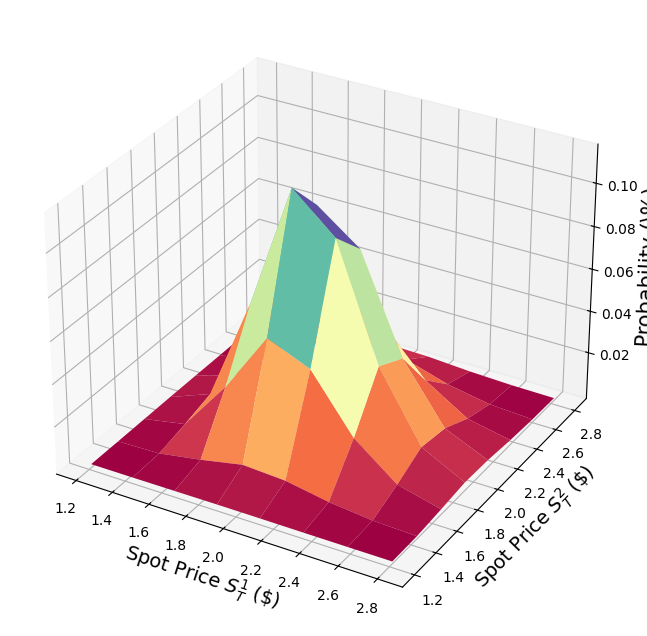

In [91]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()


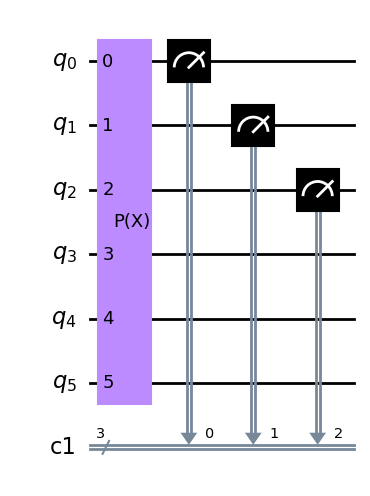

In [96]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

q_reg = QuantumRegister(u.num_qubits, name='q')
first_num_register = ClassicalRegister(num_uncertainty_qubits, name='c1')
# second_num_register = ClassicalRegister(num_uncertainty_qubits, name='c2')


test_circuit = QuantumCircuit(q_reg, first_num_register)
test_circuit.append(u, test_circuit.qubits)
test_circuit.measure(test_circuit.qubits[:num_uncertainty_qubits], first_num_register)
# test_circuit.measure(test_circuit.qubits[num_uncertainty_qubits:], first_num_register)
test_circuit.draw(output='mpl')

{'011': 342, '111': 6, '001': 22, '110': 50, '100': 288, '101': 130, '010': 162}


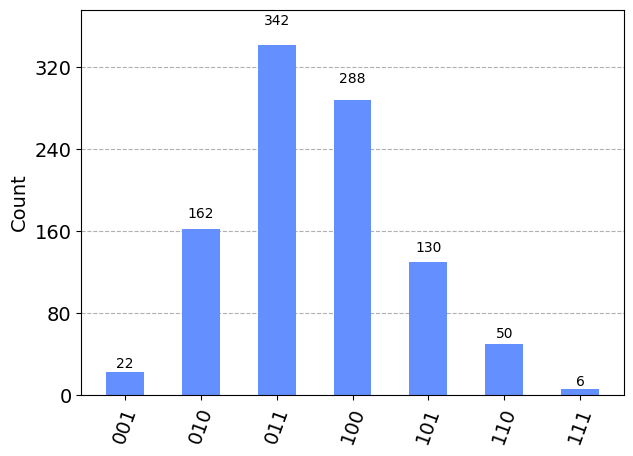

In [97]:
from qiskit import execute, Aer

job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [100]:
print([u.values[i][0] for i in range(0, len(u.values), 8)])
print([u.values[i][1] for i in range(0, 8)])


[1.2072834631468483, 1.4362842928216806, 1.6652851224965128, 1.8942859521713453, 2.1232867818461774, 2.35228761152101, 2.5812884411958423, 2.8102892708706744]
[1.2072834631468483, 1.4362842928216806, 1.6652851224965128, 1.8942859521713453, 2.1232867818461774, 2.35228761152101, 2.5812884411958423, 2.8102892708706744]


## strike 1

In [120]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.9

# set the approximation scaling for the payoff function
c_approx = 0.01

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price_1
# maximum y value

call_objective_1 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

print(call_objective_1)


         ┌────┐
q1234_0: ┤0   ├
         │    │
q1234_1: ┤1   ├
         │    │
q1234_2: ┤2   ├
         │    │
  q1235: ┤3 F ├
         │    │
 a296_0: ┤4   ├
         │    │
 a296_1: ┤5   ├
         │    │
 a296_2: ┤6   ├
         └────┘


## Strike 2

In [102]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_2 = 1.9

# set the approximation scaling for the payoff function
c_approx = 0.01

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_2] 
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price_2

call_objective_2 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

print(call_objective_2)

         ┌────┐
q1185_0: ┤0   ├
         │    │
q1185_1: ┤1   ├
         │    │
q1185_2: ┤2   ├
         │    │
  q1186: ┤3 F ├
         │    │
 a278_0: ┤4   ├
         │    │
 a278_1: ┤5   ├
         │    │
 a278_2: ┤6   ├
         └────┘


## Exact payoff

In [103]:
def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    return int((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))

strike_price_1_range = np.linspace(low, high, 10)

print("high: {}, low: {}".format(high, low))
for strike_price in strike_price_1_range:
    print("strike price: {}, mapped strike price: {}".format(strike_price, map_strike_price(strike_price, high, low, num_uncertainty_qubits)))

print("strike price: {}, mapped strike price: {}".format(1.7, map_strike_price(1.7, high, low, num_uncertainty_qubits)))
print("strike price: {}, mapped strike price: {}".format(1.9, map_strike_price(1.9, high, low, num_uncertainty_qubits)))


high: 2.8102892708706744, low: 1.2072834631468483
strike price: 1.2072834631468483, mapped strike price: 0
strike price: 1.3853952195606067, mapped strike price: 0
strike price: 1.5635069759743652, mapped strike price: 1
strike price: 1.7416187323881238, mapped strike price: 2
strike price: 1.919730488801882, mapped strike price: 3
strike price: 2.0978422452156407, mapped strike price: 3
strike price: 2.2759540016293993, mapped strike price: 4
strike price: 2.4540657580431575, mapped strike price: 5
strike price: 2.6321775144569157, mapped strike price: 6
strike price: 2.8102892708706744, mapped strike price: 7
strike price: 1.7, mapped strike price: 2
strike price: 1.9, mapped strike price: 3


## Test circuit

In [122]:
from package.helper import Subtractor
from package.qArithmetic import QComp


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = "0" * (register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])


def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    return int((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))


first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
first_compare_ancilla = QuantumRegister(1, name="c1")


second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
second_compare_ancilla = QuantumRegister(1, name="c2")

carry_register = QuantumRegister(1, name="carry")
compare_ancilla_register = QuantumRegister(3, name="comp")
objective_register = QuantumRegister(1, name="o")
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name="oa")

test_circuit = QuantumCircuit(
    first_number_register,
    first_ancilla_register,
    second_number_register,
    second_ancilla_register,
    carry_register,
    objective_register,
    compare_ancilla_register,
    objective_ancilla_register,
)
subtractor = Subtractor(num_uncertainty_qubits).circuit
controlled_first_objective = call_objective_1.to_gate().control(1)
controlled_second_objective = call_objective_2.to_gate().control(1)


# loadNumber(test_circuit, first_number_register, 4)
# loadNumber(test_circuit, second_number_register, 2)
test_circuit.append(u, first_number_register[:] + second_number_register[:])

loadNumber(
    test_circuit,
    first_ancilla_register,
    map_strike_price(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    test_circuit,
    second_ancilla_register,
    map_strike_price(strike_price_2, high, low, num_uncertainty_qubits),
)

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

# test_circuit.x(first_ancilla_register[-1])
# test_circuit.x(second_ancilla_register[-1])

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

test_circuit.append(
    comparator,
    first_ancilla_register[:]
    + second_ancilla_register[:]
    + carry_register[:]
    + compare_ancilla_register[:],
)

test_circuit.append(
    controlled_first_objective,
    [compare_ancilla_register[0]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)
test_circuit.append(
    controlled_second_objective,
    [compare_ancilla_register[1]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)
test_circuit.append(
    controlled_first_objective,
    [compare_ancilla_register[2]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)

# test_circuit.append(
#     call_objective_1,
#     first_number_register[:] + objective_register[:] + objective_ancilla_register[:],
# )

test_circuit.draw()

┌───────┐     ┌─────────────┐           ┌────┐
  q1_0: ┤0      ├─────┤0            ├───────────┤0   ├
        │       │     │             │           │    │
  q1_1: ┤1      ├─────┤1            ├───────────┤1   ├
        │       │     │             │           │    │
  q1_2: ┤2      ├─────┤2            ├───────────┤2   ├
        │       │┌───┐│             │┌─────────┐│    │
  a1_0: ┤       ├┤ X ├┤3 subtractor ├┤0        ├┤    ├
        │       │├───┤│             ││         ││    │
  a1_1: ┤       ├┤ X ├┤4            ├┤1        ├┤    ├
        │  P(X) │└───┘│             ││         ││    │
  a1_2: ┤       ├─────┤5            ├┤2        ├┤    ├
        │       │     │             ││         ││    │
  a1_3: ┤       ├─────┤6            ├┤3        ├┤    ├
        │       │     ├─────────────┤│         ││    │
  q2_0: ┤3      ├─────┤0            ├┤         ├┤    ├
        │       │     │             ││         ││    │
  q2_1: ┤4      ├─────┤1            ├┤         ├┤    ├
        │       │     │             ││         ││    │
  q2_2: ┤5      ├─────┤2            ├┤         ├┤    ├
        └───────┘┌───┐│             ││         ││    │
  a2_0: ─────────┤ X ├┤3 subtractor ├┤4        ├┤    ├
                 ├───┤│             ││   QComp ││  F │
  a2_1: ─────────┤ X ├┤4            ├┤5        ├┤    ├
                 └───┘│             ││         ││    │
  a2_2: ──────────────┤5            ├┤6        ├┤    ├
                      │             ││         ││    │
  a2_3: ──────────────┤6            ├┤7        ├┤    ├
                      └─────────────┘│         ││    │
 carry: ─────────────────────────────┤8        ├┤    ├
                                     │         ││    │
     o: ─────────────────────────────┤         ├┤3   ├
                                     │         ││    │
comp_0: ─────────────────────────────┤9        ├┤    ├
                                     │         ││    │
comp_1: ─────────────────────────────┤10       ├┤    ├
                                     │         ││    │
comp_2: ─────────────────────────────┤11       ├┤    ├
                                     └─────────┘│    │
  oa_0: ────────────────────────────────────────┤4   ├
                                                │    │
  oa_1: ────────────────────────────────────────┤5   ├
                                                │    │
  oa_2: ────────────────────────────────────────┤6   ├
                                                └────┘

In [123]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.001
alpha = 0.005

problem = EstimationProblem(
    state_preparation=test_circuit,
    objective_qubits=15,
    post_processing=call_objective_1.post_processing,
)
# construct amplitude estimation

# qi = QuantumInstance(backend=AerSimulator(), shots=200)
# ae = ModifiedIterativeAmplitudeEstimation(
#     epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
# result = ae.estimate(problem, shots=200)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 1000})
)

result = ae.estimate(problem)

In [124]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.4948317719329583, 0.49501824186102406),
    'confidence_interval_processed': (0.15564160766596832, 0.166447691940728),
    'epsilon_estimated': 9.32349640328789e-05,
    'epsilon_estimated_processed': 0.00540304213737984,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.40712914180830456, 0.5175157365429793],
                              [0.4845107925700442, 0.5003561595344079],
                              [0.49342008168931834, 0.4956865003968547],
                              [0.4948317719329583, 0.49501824186102406]],
    'estimation': 0.49492500689699115,
    'estimation_processed': 0.16104464980334654,
    'num_oracle_queries': 324000,
    'powers': [0, 0, 3, 24, 297],
    'ratios': [1.0, 7.0, 7.0, 12.142857142857142],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.11013280674676942, 0.12778828655058416],
  

In [107]:
probabilities = u.probabilities
values = u.values

# expected_payoff = 0
# for i in range(len(values)):
#     expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

special_function = lambda x: x[0] - strike_price_1 if x[0] > x[1] else 0

expected_payoff = 0
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, special_function(values[i]))
print(f"Expected payoff: {expected_payoff:.4f}")

Expected payoff: 0.1165


In [121]:
print(np.array(result.confidence_interval_processed))
c_approx = 0.01

print(np.array(result.confidence_interval)*(f_max-f_min) + f_min)
print((np.array(result.confidence_interval)-0.5 + c_approx * np.pi/4)* 2/(c_approx * np.pi)*(f_max-f_min) + f_min)
print(result.confidence_interval_processed[0] < expected_payoff < result.confidence_interval_processed[1])

[-21.46328022 -21.43299649]
[0.11085082 0.11132652]
[-21.46328022 -21.43299649]
False


## Test circuit until subtractor

In [14]:
from package.helper import Subtractor
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from package.qArithmetic import QComp

number_1 = 1
strike_price_1 = 3

number_2 = 3
strike_price_2 = 0

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

def ancilla_intepreter(ancilla_measuremnt, num_1, num_2):
    if ancilla_measuremnt == "100":
        return "equal"
    elif ancilla_measuremnt == "010":
        return "{} > {}".format(num_1, num_2)
    elif ancilla_measuremnt == "001":
        return "{} < {}".format(num_1, num_2)
    else:
        return "error"

first_number_register = QuantumRegister(num_uncertainty_qubits, name='q1')
first_ancilla_register = QuantumRegister(num_uncertainty_qubits+1, name='a1')


second_number_register = QuantumRegister(num_uncertainty_qubits, name='q2')
second_ancilla_register = QuantumRegister(num_uncertainty_qubits+1, name='a2')

first_compute_result = ClassicalRegister(num_uncertainty_qubits+1, name='c1')
second_compute_result = ClassicalRegister(num_uncertainty_qubits+1, name='c2')


test_circuit = QuantumCircuit(first_number_register, first_ancilla_register, second_number_register, second_ancilla_register, first_compute_result, second_compute_result)
subtractor = Subtractor(num_uncertainty_qubits).circuit

loadNumber(test_circuit, first_number_register, number_1)
loadNumber(test_circuit, second_number_register, number_2)

loadNumber(test_circuit, first_ancilla_register, strike_price_1)
loadNumber(test_circuit, second_ancilla_register, strike_price_2)

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

# test_circuit.x(first_ancilla_register[-1])
# test_circuit.x(second_ancilla_register[-1])

test_circuit.measure(first_ancilla_register, first_compute_result)
test_circuit.measure(second_ancilla_register, second_compute_result)
test_circuit.draw()

┌───┐┌─────────────┐                        
q1_0: ┤ X ├┤0            ├────────────────────────
      └───┘│             │                        
q1_1: ─────┤1            ├────────────────────────
           │             │                        
q1_2: ─────┤2            ├────────────────────────
      ┌───┐│             │┌─┐                     
a1_0: ┤ X ├┤3 subtractor ├┤M├─────────────────────
      ├───┤│             │└╥┘┌─┐                  
a1_1: ┤ X ├┤4            ├─╫─┤M├──────────────────
      └───┘│             │ ║ └╥┘┌─┐               
a1_2: ─────┤5            ├─╫──╫─┤M├───────────────
           │             │ ║  ║ └╥┘┌─┐            
a1_3: ─────┤6            ├─╫──╫──╫─┤M├────────────
      ┌───┐├─────────────┤ ║  ║  ║ └╥┘            
q2_0: ┤ X ├┤0            ├─╫──╫──╫──╫─────────────
      ├───┤│             │ ║  ║  ║  ║             
q2_1: ┤ X ├┤1            ├─╫──╫──╫──╫─────────────
      └───┘│             │ ║  ║  ║  ║             
q2_2: ─────┤2            ├─╫──╫──╫──╫─────────────
           │             │ ║  ║  ║  ║ ┌─┐         
a2_0: ─────┤3 subtractor ├─╫──╫──╫──╫─┤M├─────────
           │             │ ║  ║  ║  ║ └╥┘┌─┐      
a2_1: ─────┤4            ├─╫──╫──╫──╫──╫─┤M├──────
           │             │ ║  ║  ║  ║  ║ └╥┘┌─┐   
a2_2: ─────┤5            ├─╫──╫──╫──╫──╫──╫─┤M├───
           │             │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
a2_3: ─────┤6            ├─╫──╫──╫──╫──╫──╫──╫─┤M├
           └─────────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
c1: 4/═════════════════════╩══╩══╩══╩══╬══╬══╬══╬═
                           0  1  2  3  ║  ║  ║  ║ 
c2: 4/═════════════════════════════════╩══╩══╩══╩═
                                       0  1  2  3

In [15]:
from qiskit import execute, Aer

job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
first_subtract, second_subtract = list(counts.keys())[0].split(' ')

print("first subtract\t: {} - {} = {}\t".format(number_1, strike_price_1, number_1-strike_price_1), first_subtract)
print("second subtract\t: {} - {} = {}\t".format(number_2, strike_price_2, number_2-strike_price_2), second_subtract)

first subtract	: 1 - 3 = -2	 0011
second subtract	: 3 - 0 = 3	 1110


In [16]:
from package.helper import Subtractor

strike_price_1 = 3

strike_price_2 = 0


# mapped_binary_representation = {}
# for i in range(-2**num_uncertainty_qubits, 2**num_uncertainty_qubits):
#     mapped_binary_representation[i] = bin(i + 2**num_uncertainty_qubits)[2:].zfill(len(bin(2**num_uncertainty_qubits-1)[2:])+1)

mapped_int_representation = {
    "1000": -8, "1001": -7, "1010": -6, "1011": -5, "1100": -4, "1101": -3, "1110": -2, "1111": -1,
    "0000": 0, "0001": 1, "0010": 2, "0011": 3, "0100": 4, "0101": 5, "0110": 6, "0111": 7
}

mapped_binary_representation = {
    -8: "1000", -7: "1001", -6: "1010", -5: "1011", -4: "1100", -3: "1101", -2: "1110", -1: "1111",
    0: "0000", 1: "0001", 2: "0010", 3: "0011", 4: "0100", 5: "0101", 6: "0110", 7: "0111"
}

# print(mapped_binary_representation)
count = 0
for number_1 in range(2**num_uncertainty_qubits):
    for number_2 in range(2**num_uncertainty_qubits):
        first_number_register = QuantumRegister(num_uncertainty_qubits, name='q1')
        first_ancilla_register = QuantumRegister(num_uncertainty_qubits+1, name='a1')


        second_number_register = QuantumRegister(num_uncertainty_qubits, name='q2')
        second_ancilla_register = QuantumRegister(num_uncertainty_qubits+1, name='a2')

        first_compute_result = ClassicalRegister(num_uncertainty_qubits+1, name='c1')
        second_compute_result = ClassicalRegister(num_uncertainty_qubits+1, name='c2')


        test_circuit = QuantumCircuit(first_number_register, first_ancilla_register, second_number_register, second_ancilla_register, first_compute_result, second_compute_result)
        subtractor = Subtractor(num_uncertainty_qubits).circuit

        loadNumber(test_circuit, first_number_register, number_1)
        loadNumber(test_circuit, second_number_register, number_2)

        loadNumber(test_circuit, first_ancilla_register, strike_price_1)
        loadNumber(test_circuit, second_ancilla_register, strike_price_2)

        test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
        test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

        # test_circuit.x(first_ancilla_register[-1])
        # test_circuit.x(second_ancilla_register[-1])

        test_circuit.measure(first_ancilla_register, first_compute_result)
        test_circuit.measure(second_ancilla_register, second_compute_result)
        if number_1 == 0 and number_2 == 0:
            print(test_circuit)
        job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
        results = job.result()
        counts = results.get_counts()
        second_subtract, first_subtract = list(counts.keys())[0].split(' ')

        mapped_subtract_result_1 = mapped_binary_representation[number_1-strike_price_1]
        correct_first_subtract = mapped_subtract_result_1 == first_subtract
        
        mapped_subtract_ressult_2 = mapped_binary_representation[number_2-strike_price_2]
        correct_second_subtract = mapped_subtract_ressult_2 == second_subtract
        
        print("first subtract\t: {} - {} = {}\t".format(number_1, strike_price_1, number_1-strike_price_1), first_subtract, correct_first_subtract)
        print("second subtract\t: {} - {} = {}\t".format(number_2, strike_price_2, number_2-strike_price_2), second_subtract, correct_second_subtract)
        print()

                     ┌─────────────┐                     
q1_0: ───────────────┤0            ├─────────────────────
                     │             │                     
q1_1: ───────────────┤1            ├─────────────────────
                     │             │                     
q1_2: ───────────────┤2            ├─────────────────────
           ┌───┐     │             │         ┌─┐         
a1_0: ─────┤ X ├─────┤3 subtractor ├─────────┤M├─────────
           ├───┤     │             │         └╥┘┌─┐      
a1_1: ─────┤ X ├─────┤4            ├──────────╫─┤M├──────
           └───┘     │             │          ║ └╥┘┌─┐   
a1_2: ───────────────┤5            ├──────────╫──╫─┤M├───
                     │             │          ║  ║ └╥┘┌─┐
a1_3: ───────────────┤6            ├──────────╫──╫──╫─┤M├
      ┌─────────────┐└─────────────┘          ║  ║  ║ └╥┘
q2_0: ┤0            ├─────────────────────────╫──╫──╫──╫─
      │             │                         ║  ║  ║  ║ 
q2_1: ┤1      

## test circuit until comparator

In [17]:
from package.helper import Subtractor
from package.qArithmetic import QComp

number_1 = 2
strike_price_1 = 3

number_2 = 6
strike_price_2 = 0


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = "0" * (register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])


def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    return int((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))


def ancilla_intepreter(ancilla_measuremnt, num_1, num_2):
    if ancilla_measuremnt == "100":
        return "{} == {}".format(num_1, num_2)
    elif ancilla_measuremnt == "010":
        return "{} > {}".format(num_1, num_2)
    elif ancilla_measuremnt == "001":
        return "{} < {}".format(num_1, num_2)
    else:
        return "error"


first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
first_compare_register = QuantumRegister(1, name="comp1")

second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
second_compare_register = QuantumRegister(1, name="comp2")

carry_register = QuantumRegister(1, name="carry")
compare_ancilla_register = QuantumRegister(3, name="comp")
objective_register = QuantumRegister(1, name="o")
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name="oa")

compare_results = ClassicalRegister(3, name="compare")

classical_results_num_1 = ClassicalRegister(num_uncertainty_qubits + 1, name="c1")
classical_results_num_2 = ClassicalRegister(num_uncertainty_qubits + 1, name="c2")

test_circuit = QuantumCircuit(
    first_number_register,
    first_ancilla_register,
    second_number_register,
    second_ancilla_register,
    carry_register,
    compare_ancilla_register,
    objective_ancilla_register,
    compare_results,
    classical_results_num_1,
    classical_results_num_2,
)
subtractor = Subtractor(num_uncertainty_qubits).circuit
controlled_first_objective = call_objective_1.to_gate().control(1)
controlled_second_objective = call_objective_2.to_gate().control(1)


loadNumber(test_circuit, first_number_register, number_1)
loadNumber(test_circuit, second_number_register, number_2)
# test_circuit.append(u, first_number_register[:] + second_number_register[:])

loadNumber(test_circuit, first_ancilla_register, strike_price_1)
loadNumber(test_circuit, second_ancilla_register, strike_price_2)

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

# test_circuit.x(first_ancilla_register[-1])
# test_circuit.x(second_ancilla_register[-1])

# test_circuit.measure(first_ancilla_register, classical_results_num_1)
# test_circuit.measure(second_ancilla_register, classical_results_num_2)

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

test_circuit.append(
    comparator,
    first_ancilla_register[:]
    + second_ancilla_register[:]
    + carry_register[:]
    + compare_ancilla_register[:],
)
test_circuit.measure(compare_ancilla_register, compare_results)
test_circuit.draw()

┌─────────────┐                    
     q1_0: ─────┤0            ├────────────────────
           ┌───┐│             │                    
     q1_1: ┤ X ├┤1            ├────────────────────
           └───┘│             │                    
     q1_2: ─────┤2            ├────────────────────
           ┌───┐│             │┌─────────┐         
     a1_0: ┤ X ├┤3 subtractor ├┤0        ├─────────
           ├───┤│             ││         │         
     a1_1: ┤ X ├┤4            ├┤1        ├─────────
           └───┘│             ││         │         
     a1_2: ─────┤5            ├┤2        ├─────────
                │             ││         │         
     a1_3: ─────┤6            ├┤3        ├─────────
                ├─────────────┤│         │         
     q2_0: ─────┤0            ├┤         ├─────────
           ┌───┐│             ││         │         
     q2_1: ┤ X ├┤1            ├┤         ├─────────
           ├───┤│             ││         │         
     q2_2: ┤ X ├┤2            ├┤         ├─────────
           └───┘│             ││         │         
     a2_0: ─────┤3 subtractor ├┤4  QComp ├─────────
                │             ││         │         
     a2_1: ─────┤4            ├┤5        ├─────────
                │             ││         │         
     a2_2: ─────┤5            ├┤6        ├─────────
                │             ││         │         
     a2_3: ─────┤6            ├┤7        ├─────────
                └─────────────┘│         │         
    carry: ────────────────────┤8        ├─────────
                               │         │┌─┐      
   comp_0: ────────────────────┤9        ├┤M├──────
                               │         │└╥┘┌─┐   
   comp_1: ────────────────────┤10       ├─╫─┤M├───
                               │         │ ║ └╥┘┌─┐
   comp_2: ────────────────────┤11       ├─╫──╫─┤M├
                               └─────────┘ ║  ║ └╥┘
     oa_0: ────────────────────────────────╫──╫──╫─
                                           ║  ║  ║ 
     oa_1: ────────────────────────────────╫──╫──╫─
                                           ║  ║  ║ 
     oa_2: ────────────────────────────────╫──╫──╫─
                                           ║  ║  ║ 
compare: 3/════════════════════════════════╩══╩══╩═
                                           0  1  2 
     c1: 4/════════════════════════════════════════
                                                   
     c2: 4/════════════════════════════════════════

In [18]:
from qiskit import execute, Aer

job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()

print(counts)
result = list(counts.keys())[0]

print("first subtract\t: {} - {} = {}\t".format(number_1, strike_price_1, number_1 - strike_price_1))
print("second subtract\t: {} - {} = {}\t".format(number_2, strike_price_2, number_2 - strike_price_2))
print("compare ", number_1 - strike_price_1, number_2 - strike_price_2)
print(
    ancilla_intepreter(
        result.split(" ")[-1], number_1 - strike_price_1, number_2 - strike_price_2
    )
)

print(eval(ancilla_intepreter(result.split(" ")[-1], number_1 - strike_price_1, number_2 - strike_price_2)))

{'0000 0000 001': 1000}
first subtract	: 2 - 3 = -1	
second subtract	: 6 - 0 = 6	
compare  -1 6
-1 < 6
True


In [19]:
for first_num in range(2 ** (num_uncertainty_qubits)):
    for second_num in range(2 ** (num_uncertainty_qubits)):
        first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
        first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
        first_compare_register = QuantumRegister(1, name="comp1")

        second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
        second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
        second_compare_register = QuantumRegister(1, name="comp2")

        carry_register = QuantumRegister(1, name="carry")
        compare_ancilla_register = QuantumRegister(3, name="comp")
        compare_results = ClassicalRegister(3, name="compare")

        test_circuit = QuantumCircuit(
            first_number_register,
            first_ancilla_register,
            second_number_register,
            second_ancilla_register,
            carry_register,
            compare_ancilla_register,
            compare_results,
        )
        
        subtractor = Subtractor(num_uncertainty_qubits).circuit
        controlled_first_objective = call_objective_1.to_gate().control(1)
        controlled_second_objective = call_objective_2.to_gate().control(1)

        loadNumber(test_circuit, first_number_register, first_num)
        loadNumber(test_circuit, second_number_register, second_num)
        # test_circuit.append(u, first_number_register[:] + second_number_register[:])

        loadNumber(test_circuit, first_ancilla_register, strike_price_1)
        loadNumber(test_circuit, second_ancilla_register, strike_price_2)

        test_circuit.append(
            subtractor, first_number_register[:] + first_ancilla_register[:]
        )
        test_circuit.append(
            subtractor, second_number_register[:] + second_ancilla_register[:]
        )

        # test_circuit.x(first_ancilla_register[-1])
        # test_circuit.x(second_ancilla_register[-1])

        comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

        test_circuit.append(
            comparator,
            first_ancilla_register[:]
            + second_ancilla_register[:]
            + carry_register[:]
            + compare_ancilla_register[:],
        )
        test_circuit.measure(compare_ancilla_register, compare_results)
        job = execute(test_circuit, Aer.get_backend("aer_simulator"), shots=1000)
        results = job.result()
        counts = results.get_counts()
        result = list(counts.keys())[0]
        print("first subtract\t: {} - {} = {}\t".format(first_num, strike_price_1, first_num - strike_price_1))
        print("second subtract\t: {} - {} = {}\t".format(second_num, strike_price_2, second_num - strike_price_2))
        print("compare ", first_num - strike_price_1, second_num - strike_price_2)
        print(
            ancilla_intepreter(
                result, first_num - strike_price_1, second_num - strike_price_2
            )
        )
        print(result)
        print(eval(ancilla_intepreter(result, first_num - strike_price_1, second_num - strike_price_2)))
        print()

first subtract	: 0 - 3 = -3	
second subtract	: 0 - 0 = 0	
compare  -3 0
-3 < 0
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 1 - 0 = 1	
compare  -3 1
-3 < 1
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 2 - 0 = 2	
compare  -3 2
-3 < 2
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 3 - 0 = 3	
compare  -3 3
-3 < 3
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 4 - 0 = 4	
compare  -3 4
-3 < 4
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 5 - 0 = 5	
compare  -3 5
-3 < 5
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 6 - 0 = 6	
compare  -3 6
-3 < 6
001
True

first subtract	: 0 - 3 = -3	
second subtract	: 7 - 0 = 7	
compare  -3 7
-3 < 7
001
True

first subtract	: 1 - 3 = -2	
second subtract	: 0 - 0 = 0	
compare  -2 0
-2 < 0
001
True

first subtract	: 1 - 3 = -2	
second subtract	: 1 - 0 = 1	
compare  -2 1
-2 < 1
001
True

first subtract	: 1 - 3 = -2	
second subtract	: 2 - 0 = 2	
compare  -2 2
-2 < 2
001
True

first subtract	: 1 - 

## Check discretization

(16,)


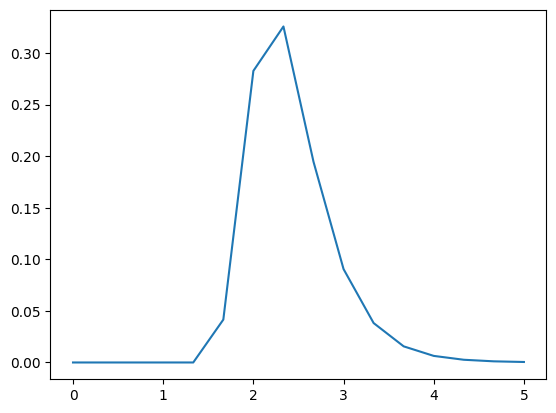

In [20]:
from scipy.stats import lognorm
import math

mean = 1.5
sd = 0.4

dist=lognorm([sd],loc=mean)

num_discrete = 16

x_values = np.linspace(0, 5, num_discrete)
prob_values = []

for i in range(num_discrete-1):
    curr_prob_value = dist.cdf(x_values[i+1]) - dist.cdf(x_values[i])
    prob_values.append(curr_prob_value)
    
prob_values.append(dist.cdf(x_values[-1]+ (x_values[-1] - x_values[-2])) - dist.cdf(x_values[-1]))

prob_values = np.array(prob_values).reshape(-1)
print(prob_values.shape)
plt.plot(x_values,prob_values)


In [21]:
strike_price = 3
payoff = np.dot(prob_values, np.maximum(0, x_values - strike_price))
print(payoff)

0.03585556940524595


In [22]:
mapped_strike_price = int((strike_price - 0) / (5 - 0) * ((num_discrete)))
discrete_x_values = np.array(list(range(num_discrete)))

payoff = np.dot(prob_values, np.maximum(0, discrete_x_values - mapped_strike_price))/(num_discrete)*5
print(payoff)

0.03361459631741809


## Test loading of fixed value

In [23]:
# check discrete values
# print([u.values[i][0] for i in range(0, len(u.values), 8)])
for i in range(0, len(u.values), 8):
    print(int(i/8), u.values[i][0])

0 1.2072834631468483
1 1.4362842928216806
2 1.6652851224965128
3 1.8942859521713453
4 2.1232867818461774
5 2.35228761152101
6 2.5812884411958423
7 2.8102892708706744


In [24]:
from qiskit.circuit.library import LinearAmplitudeFunction

strike_price_1 = 1.9
strike_price_2 = 1.7

first_number = 6
second_number = 2

# set the approximation scaling for the payoff function
c_approx = 0.01

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price_1
# maximum y value

call_objective_1 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_2] 
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price_2

call_objective_2 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

from package.helper import Subtractor
from package.qArithmetic import QComp

def swap_all(circuit, qubits):
    for i in range(len(qubits)//2):
        circuit.swap(qubits[i], qubits[len(qubits)-i-1])


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = "0" * (register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])


def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    return int((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))


first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
first_compare_ancilla = QuantumRegister(1, name="c1")


second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
second_compare_ancilla = QuantumRegister(1, name="c2")

carry_register = QuantumRegister(1, name="carry")
compare_ancilla_register = QuantumRegister(3, name="comp")
objective_register = QuantumRegister(1, name="o")
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name="oa")

test_circuit = QuantumCircuit(
    first_number_register,
    first_ancilla_register,
    second_number_register,
    second_ancilla_register,
    carry_register,
    objective_register,
    compare_ancilla_register,
    objective_ancilla_register,
)
subtractor = Subtractor(num_uncertainty_qubits).circuit
controlled_first_objective = call_objective_1.to_gate().control(1)
controlled_second_objective = call_objective_2.to_gate().control(1)


loadNumber(test_circuit, first_number_register, first_number)
# swap_all(test_circuit, first_number_register)
loadNumber(test_circuit, second_number_register, second_number)
# test_circuit.append(u, first_number_register[:] + second_number_register[:])

loadNumber(
    test_circuit,
    first_ancilla_register,
    map_strike_price(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    test_circuit,
    second_ancilla_register,
    map_strike_price(strike_price_2, high, low, num_uncertainty_qubits),
)

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

# test_circuit.x(first_ancilla_register[-1])
# test_circuit.x(second_ancilla_register[-1])

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

test_circuit.append(
    comparator,
    first_ancilla_register[:]
    + second_ancilla_register[:]
    + carry_register[:]
    + compare_ancilla_register[:],
)

test_circuit.append(
    controlled_first_objective,
    [compare_ancilla_register[0]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)
test_circuit.append(
    controlled_second_objective,
    [compare_ancilla_register[1]]
    + second_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)
test_circuit.append(
    controlled_first_objective,
    [compare_ancilla_register[2]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)

test_circuit.draw()

┌─────────────┐           ┌────┐      ┌────┐
  q1_0: ─────┤0            ├───────────┤0   ├──────┤0   ├
        ┌───┐│             │           │    │      │    │
  q1_1: ┤ X ├┤1            ├───────────┤1   ├──────┤1   ├
        ├───┤│             │           │    │      │    │
  q1_2: ┤ X ├┤2            ├───────────┤2   ├──────┤2   ├
        ├───┤│             │┌─────────┐│    │      │    │
  a1_0: ┤ X ├┤3 subtractor ├┤0        ├┤    ├──────┤    ├
        └───┘│             ││         ││    │      │    │
  a1_1: ─────┤4            ├┤1        ├┤    ├──────┤    ├
        ┌───┐│             ││         ││    │      │    │
  a1_2: ┤ X ├┤5            ├┤2        ├┤    ├──────┤    ├
        └───┘│             ││         ││    │      │    │
  a1_3: ─────┤6            ├┤3        ├┤    ├──────┤    ├
             ├─────────────┤│         ││    │┌────┐│    │
  q2_0: ─────┤0            ├┤         ├┤    ├┤0   ├┤    ├
        ┌───┐│             ││         ││    ││    ││    │
  q2_1: ┤ X ├┤1            ├┤         ├┤    ├┤1   ├┤    ├
        └───┘│             ││         ││    ││    ││    │
  q2_2: ─────┤2            ├┤         ├┤    ├┤2   ├┤    ├
             │             ││         ││    ││    ││    │
  a2_0: ─────┤3 subtractor ├┤4        ├┤    ├┤    ├┤    ├
             │             ││   QComp ││  F ││    ││  F │
  a2_1: ─────┤4            ├┤5        ├┤    ├┤    ├┤    ├
        ┌───┐│             ││         ││    ││    ││    │
  a2_2: ┤ X ├┤5            ├┤6        ├┤    ├┤    ├┤    ├
        └───┘│             ││         ││    ││    ││    │
  a2_3: ─────┤6            ├┤7        ├┤    ├┤    ├┤    ├
             └─────────────┘│         ││    ││    ││    │
 carry: ────────────────────┤8        ├┤    ├┤  F ├┤    ├
                            │         ││    ││    ││    │
     o: ────────────────────┤         ├┤3   ├┤3   ├┤3   ├
                            │         ││    ││    ││    │
comp_0: ────────────────────┤9        ├■    ├┤    ├┤    ├
                            │         ││    ││    ││    │
comp_1: ────────────────────┤10       ├┤    ├■    ├┤    ├
                            │         ││    ││    ││    │
comp_2: ────────────────────┤11       ├┤    ├┤    ├■    ├
                            └─────────┘│    ││    ││    │
  oa_0: ───────────────────────────────┤4   ├┤4   ├┤4   ├
                                       │    ││    ││    │
  oa_1: ───────────────────────────────┤5   ├┤5   ├┤5   ├
                                       │    ││    ││    │
  oa_2: ───────────────────────────────┤6   ├┤6   ├┤6   ├
                                       └────┘└────┘└────┘

In [25]:
# set target precision and confidence level
from qiskit_algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.001
alpha = 0.005

problem = EstimationProblem(
    state_preparation=test_circuit,
    objective_qubits=15,
    post_processing=call_objective_1.post_processing,
)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 1000})
)

result = ae.estimate(problem)

In [26]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.4920142801804633, 0.4921924376213498),
    'confidence_interval_processed': (   -0.003367289772103175,
                                         0.0011864979240071751),
    'epsilon_estimated': 8.907872044325305e-05,
    'epsilon_estimated_processed': 0.002276893848055175,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.4219015907578351, 0.5324887219670408],
                              [0.48425863523765295, 0.4965830230984876],
                              [0.49120202355893344, 0.4934715855857398],
                              [0.4920142801804633, 0.4921924376213498]],
    'estimation': 0.4921033589009065,
    'estimation_processed': -0.0010903959240487096,
    'num_oracle_queries': 339000,
    'powers': [0, 0, 4, 24, 311],
    'ratios': [1.0, 9.0, 5.444444444444445, 12.714285714285714],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
       

In [27]:
print(np.array(result.confidence_interval_processed))
print(np.array(result.confidence_interval)/(2**num_uncertainty_qubits - 1)*(high-low))
print(result.confidence_interval_processed[0] < expected_payoff < result.confidence_interval_processed[1])

[-0.00336729  0.0011865 ]
[0.11267168 0.11271248]
False


# Test brute force sampling

In [28]:
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [29]:
# first_number = 4
# second_number = 5

strike_price_1 = 1.9
strike_price_2 = 1.4

strike_price_1_list = np.linspace(1.5, 2.5, 10)
strike_price_2_list = np.linspace(1.5, 2.5, 10)

first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
first_compare_ancilla = QuantumRegister(1, name="c1")


second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
second_compare_ancilla = QuantumRegister(1, name="c2")

carry_register = QuantumRegister(1, name="carry")
compare_ancilla_register = QuantumRegister(3, name="comp")
objective_register = QuantumRegister(1, name="o")
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name="oa")

measure_first_num = ClassicalRegister(num_uncertainty_qubits, name="first_num")
measure_second_num = ClassicalRegister(num_uncertainty_qubits, name="second_num")
measure_comp = ClassicalRegister(3, name="m_comp")

test_circuit = QuantumCircuit(
    first_number_register,
    first_ancilla_register,
    second_number_register,
    second_ancilla_register,
    carry_register,
    objective_register,
    compare_ancilla_register,
    objective_ancilla_register,
    measure_first_num,
    measure_second_num,
    measure_comp,
)

subtractor = Subtractor(num_uncertainty_qubits).circuit
controlled_first_objective = call_objective_1.to_gate().control(1)
controlled_second_objective = call_objective_2.to_gate().control(1)


# loadNumber(test_circuit, first_number_register, first_number)
# swap_all(test_circuit, first_number_register)

# test_circuit.append(uncertainty_model, first_number_register)
# loadNumber(test_circuit, second_number_register, second_number)
test_circuit.append(u, first_number_register[:] + second_number_register[:])

loadNumber(
    test_circuit,
    first_ancilla_register,
    map_strike_price(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    test_circuit,
    second_ancilla_register,
    map_strike_price(strike_price_2, high, low, num_uncertainty_qubits),
)

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

# test_circuit.x(first_ancilla_register[-1])
# test_circuit.x(second_ancilla_register[-1])

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

test_circuit.append(comparator, first_ancilla_register[:] + second_ancilla_register[:] + carry_register[:] + compare_ancilla_register[:])
# test_circuit.append(call_objective_1, first_number_register[:] + objective_register[:]+objective_ancilla_register[:])
test_circuit.barrier()
test_circuit.measure(compare_ancilla_register, measure_comp)
test_circuit.measure(first_number_register, measure_first_num)
test_circuit.measure(second_number_register, measure_second_num)

test_circuit.draw()

┌───────┐               ┌─────────────┐            ░          ┌─┐»
        q1_0: ┤0      ├───────────────┤0            ├────────────░──────────┤M├»
              │       │               │             │            ░          └╥┘»
        q1_1: ┤1      ├───────────────┤1            ├────────────░───────────╫─»
              │       │               │             │            ░           ║ »
        q1_2: ┤2      ├───────────────┤2            ├────────────░───────────╫─»
              │       │     ┌───┐     │             │┌─────────┐ ░           ║ »
        a1_0: ┤       ├─────┤ X ├─────┤3 subtractor ├┤0        ├─░───────────╫─»
              │       │     ├───┤     │             ││         │ ░           ║ »
        a1_1: ┤       ├─────┤ X ├─────┤4            ├┤1        ├─░───────────╫─»
              │  P(X) │     └───┘     │             ││         │ ░           ║ »
        a1_2: ┤       ├───────────────┤5            ├┤2        ├─░───────────╫─»
              │       │               │             ││         │ ░           ║ »
        a1_3: ┤       ├───────────────┤6            ├┤3        ├─░───────────╫─»
              │       │┌─────────────┐└─────────────┘│         │ ░           ║ »
        q2_0: ┤3      ├┤0            ├───────────────┤         ├─░───────────╫─»
              │       ││             │               │         │ ░           ║ »
        q2_1: ┤4      ├┤1            ├───────────────┤         ├─░───────────╫─»
              │       ││             │               │         │ ░           ║ »
        q2_2: ┤5      ├┤2            ├───────────────┤         ├─░───────────╫─»
              └───────┘│             │               │         │ ░           ║ »
        a2_0: ─────────┤3 subtractor ├───────────────┤4        ├─░───────────╫─»
                       │             │               │   QComp │ ░           ║ »
        a2_1: ─────────┤4            ├───────────────┤5        ├─░───────────╫─»
                       │             │               │         │ ░           ║ »
        a2_2: ─────────┤5            ├───────────────┤6        ├─░───────────╫─»
                       │             │               │         │ ░           ║ »
        a2_3: ─────────┤6            ├───────────────┤7        ├─░───────────╫─»
                       └─────────────┘               │         │ ░           ║ »
       carry: ───────────────────────────────────────┤8        ├─░───────────╫─»
                                                     │         │ ░           ║ »
           o: ───────────────────────────────────────┤         ├─░───────────╫─»
                                                     │         │ ░ ┌─┐       ║ »
      comp_0: ───────────────────────────────────────┤9        ├─░─┤M├───────╫─»
                                                     │         │ ░ └╥┘┌─┐    ║ »
      comp_1: ───────────────────────────────────────┤10       ├─░──╫─┤M├────╫─»
                                                     │         │ ░  ║ └╥┘┌─┐ ║ »
      comp_2: ───────────────────────────────────────┤11       ├─░──╫──╫─┤M├─╫─»
                                                     └─────────┘ ░  ║  ║ └╥┘ ║ »
        oa_0: ───────────────────────────────────────────────────░──╫──╫──╫──╫─»
                                                                 ░  ║  ║  ║  ║ »
        oa_1: ───────────────────────────────────────────────────░──╫──╫──╫──╫─»
                                                                 ░  ║  ║  ║  ║ »
        oa_2: ───────────────────────────────────────────────────░──╫──╫──╫──╫─»
                                                                 ░  ║  ║  ║  ║ »
 first_num: 3/══════════════════════════════════════════════════════╬══╬══╬══╩═»
                                                                    ║  ║  ║  0 »
second_num: 3/══════════════════════════════════════════════════════╬══╬══╬════»
                                                                    ║  ║  ║    »
    m_comp: 3/═══════════════════════════════

{'001 111 001': 1, '010 000 100': 2, '001 101 000': 2, '001 010 000': 1, '001 011 000': 4, '001 110 001': 6, '001 001 001': 4, '001 101 010': 239, '001 001 010': 28, '100 000 011': 2, '001 111 000': 1, '010 010 111': 15, '001 110 010': 51, '001 111 010': 16, '001 010 010': 271, '001 110 110': 9, '001 111 101': 10, '010 001 111': 1, '010 001 110': 10, '100 011 110': 111, '001 110 111': 3, '001 101 001': 25, '100 010 101': 227, '001 100 011': 1026, '001 110 100': 83, '001 011 001': 83, '001 101 111': 14, '001 101 100': 397, '001 010 001': 35, '001 100 001': 70, '001 100 010': 489, '001 111 100': 19, '001 110 011': 139, '001 110 101': 43, '001 011 011': 1137, '100 100 111': 23, '010 010 110': 57, '001 111 110': 1, '100 001 100': 62, '010 001 101': 30, '001 010 011': 586, '001 100 110': 101, '001 111 011': 30, '001 011 100': 958, '001 001 011': 79, '001 011 101': 471, '001 010 100': 512, '001 101 101': 200, '001 011 010': 607, '010 011 111': 31, '001 101 011': 494, '001 100 101': 355, '001

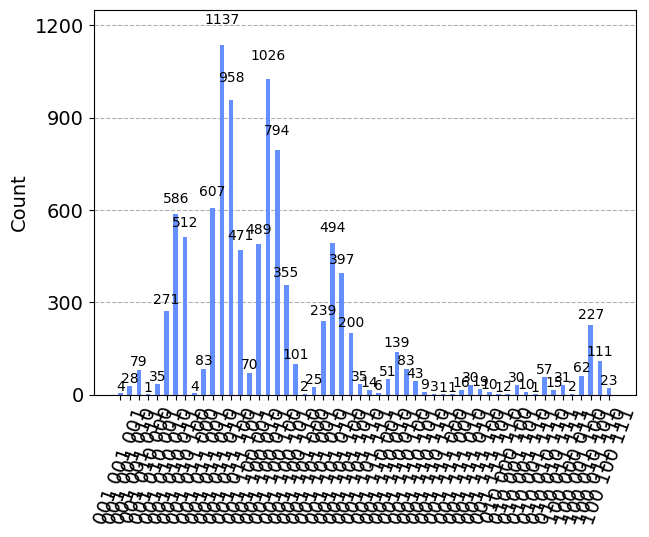

In [30]:
from qiskit import QuantumCircuit, execute, Aer

job = execute(test_circuit, Aer.get_backend('qasm_simulator'), shots=10000)
counts = job.result().get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [31]:
value_mapper = {}

for i in range(0, len(u.values), 8):
    value_mapper[int(i/8)] = u.values[i][0]
    
expected_value = 0
for key, count in counts.items():
    split_key = key.split(" ")
    first_num = split_key[2]
    second_num = split_key[1]
    comp = split_key[0]
    if comp == "100":
        expected_value += max(value_mapper[int(first_num,2)]- strike_price_1, 0) * count/10000
    elif comp == "010":
        expected_value += max(value_mapper[int(first_num,2)]- strike_price_1, 0) * count/10000
    elif comp == "001":
        expected_value += max(value_mapper[int(second_num,2)]- strike_price_2, 0) * count/10000
    else:
        print("error")
        
print(expected_value)

0.6197630530202032


In [32]:
probabilities = u.probabilities
values = u.values

expected_payoff = 0
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print(f"Expected payoff: {expected_payoff:.4f}")

Expected payoff: 0.6224


In [33]:
# first_number = 4
# second_number = 5

strike_price_1 = 1.9
strike_price_2 = 1.4

strike_price_1_list = np.linspace(1.5, 2.5, 10)
strike_price_2_list = np.linspace(1.5, 2.5, 10)

first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
first_compare_ancilla = QuantumRegister(1, name="c1")

second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
second_compare_ancilla = QuantumRegister(1, name="c2")

carry_register = QuantumRegister(1, name="carry")
compare_ancilla_register = QuantumRegister(3, name="comp")
objective_register = QuantumRegister(1, name="o")
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name="oa")

measure_first_num = ClassicalRegister(num_uncertainty_qubits, name="first_num")
measure_second_num = ClassicalRegister(num_uncertainty_qubits, name="second_num")
measure_comp = ClassicalRegister(3, name="m_comp")

def create_test_circuit(strike_price_1, strike_price_2):
    test_circuit = QuantumCircuit(
        first_number_register,
        first_ancilla_register,
        second_number_register,
        second_ancilla_register,
        carry_register,
        objective_register,
        compare_ancilla_register,
        objective_ancilla_register,
        measure_first_num,
        measure_second_num,
        measure_comp,
    )

    subtractor = Subtractor(num_uncertainty_qubits).circuit
    test_circuit.append(u, first_number_register[:] + second_number_register[:])

    loadNumber(
        test_circuit,
        first_ancilla_register,
        map_strike_price(strike_price_1, high, low, num_uncertainty_qubits),
    )
    loadNumber(
        test_circuit,
        second_ancilla_register,
        map_strike_price(strike_price_2, high, low, num_uncertainty_qubits),
    )

    test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
    test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

    comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

    test_circuit.append(comparator, first_ancilla_register[:] + second_ancilla_register[:] + carry_register[:] + compare_ancilla_register[:])
    test_circuit.barrier()
    test_circuit.measure(compare_ancilla_register, measure_comp)
    test_circuit.measure(first_number_register, measure_first_num)
    test_circuit.measure(second_number_register, measure_second_num)
    
    return test_circuit

def evaluate_expected_value(counts):
    expected_value = 0
    for key, count in counts.items():
        split_key = key.split(" ")
        first_num = split_key[2]
        second_num = split_key[1]
        comp = split_key[0]
        if comp == "100":
            expected_value += max(value_mapper[int(first_num,2)]- strike_price_1, 0) * count/10000
        elif comp == "010":
            expected_value += max(value_mapper[int(first_num,2)]- strike_price_1, 0) * count/10000
        elif comp == "001":
            expected_value += max(value_mapper[int(second_num,2)]- strike_price_2, 0) * count/10000
        else:
            print("error")
    return expected_value

def evaluate_exact_expected_value(u):
    probabilities = u.probabilities
    values = u.values

    expected_payoff = 0
    for i in range(len(values)):
        expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)
    return expected_payoff

In [34]:
min_error = 1
max_error = 0
for strike_price_1 in strike_price_1_list:
    for strike_price_2 in strike_price_2_list:
        test_circuit = create_test_circuit(strike_price_1, strike_price_2)
        job = execute(test_circuit, Aer.get_backend('qasm_simulator'), shots=10000)
        counts = job.result().get_counts()
        expected_value = evaluate_expected_value(counts)
        expected_value_exact = evaluate_exact_expected_value(u)
        error = abs(expected_value - expected_value_exact)
        if error < min_error:
            min_error = error
        if error > max_error:
            max_error = error
        print(f"Expected value: {expected_value:.4f}, Exact: {expected_value_exact:.4f}, Error: {error}, Strike price 1: {strike_price_1}, Strike price 2: {strike_price_2}")
        
print(f"Min error: {min_error}, Max error: {max_error}")

Expected value: 0.6537, Exact: 0.6509, Error: 0.0028120569946807894, Strike price 1: 1.5, Strike price 2: 1.5
Expected value: 0.6105, Exact: 0.6091, Error: 0.0014278978356974115, Strike price 1: 1.5, Strike price 2: 1.6111111111111112
Expected value: 0.5671, Exact: 0.5675, Error: 0.00036599600367470675, Strike price 1: 1.5, Strike price 2: 1.7222222222222223
Expected value: 0.5438, Exact: 0.5468, Error: 0.003042936135474461, Strike price 1: 1.5, Strike price 2: 1.8333333333333333
Expected value: 0.5298, Exact: 0.5279, Error: 0.0018512503744636533, Strike price 1: 1.5, Strike price 2: 1.9444444444444444
Expected value: 0.5196, Exact: 0.5199, Error: 0.00030896444307926263, Strike price 1: 1.5, Strike price 2: 2.0555555555555554
Expected value: 0.5125, Exact: 0.5135, Error: 0.0009857875665088, Strike price 1: 1.5, Strike price 2: 2.1666666666666665
Expected value: 0.5115, Exact: 0.5111, Error: 0.0004138902194019689, Strike price 1: 1.5, Strike price 2: 2.2777777777777777
Expected value: 0

Therefore, the loading of the probabilities before the payoff function is *correct*

We now test the payoff function

In [55]:

import numpy as np

from qiskit.circuit.library import LinearAmplitudeFunction

strike_price_1 = 1.9
strike_price_2 = 1.9

# first_number = 6
# second_number = 2

# set the approximation scaling for the payoff function
c_approx = 0.005

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1] 
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max_1 = high - strike_price_1
# maximum y value


# setup piecewise linear objective fcuntion
# low smallest value of x
# at strike price 2, I change to another linear function
breakpoints = [low, strike_price_2] 
# first breakpoint 0, my slope (alpha =0) => flat
# second breakpoint strike price 2, my slope (alpha =1) => y=x
slopes = [0, 1]
# at each breakpoint, is there a offset from the value/discontinuity
offsets = [0, 0]
f_min = 0
f_max_2 = high - strike_price_2



f_max = max(f_max_1, f_max_2)

print(f_max_1)
print(f_max_2)

call_objective_1 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max_1),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)



call_objective_2 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max_2),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

from package.helper import Subtractor
from package.qArithmetic import QComp

def swap_all(circuit, qubits):
    for i in range(len(qubits)//2):
        circuit.swap(qubits[i], qubits[len(qubits)-i-1])


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = "0" * (register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])


def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    return int((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))


first_number_register = QuantumRegister(num_uncertainty_qubits, name="q1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a1")
first_compare_ancilla = QuantumRegister(1, name="c1")


second_number_register = QuantumRegister(num_uncertainty_qubits, name="q2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits + 1, name="a2")
second_compare_ancilla = QuantumRegister(1, name="c2")

carry_register = QuantumRegister(1, name="carry")
compare_ancilla_register = QuantumRegister(3, name="comp")
objective_register = QuantumRegister(1, name="o")
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name="oa")

test_circuit = QuantumCircuit(
    first_number_register,
    first_ancilla_register,
    second_number_register,
    second_ancilla_register,
    carry_register,
    objective_register,
    compare_ancilla_register,
    objective_ancilla_register,
)
subtractor = Subtractor(num_uncertainty_qubits).circuit
controlled_first_objective = call_objective_1.to_gate().control(1)
controlled_second_objective = call_objective_2.to_gate().control(1)


# loadNumber(test_circuit, first_number_register, first_number)
# swap_all(test_circuit, first_number_register)
# loadNumber(test_circuit, second_number_register, second_number)
test_circuit.append(u, first_number_register[:] + second_number_register[:])

loadNumber(
    test_circuit,
    first_ancilla_register,
    map_strike_price(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    test_circuit,
    second_ancilla_register,
    map_strike_price(strike_price_2, high, low, num_uncertainty_qubits),
)

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

# test_circuit.x(first_ancilla_register[-1])
# test_circuit.x(second_ancilla_register[-1])

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)

test_circuit.append(
    comparator,
    first_ancilla_register[:]
    + second_ancilla_register[:]
    + carry_register[:]
    + compare_ancilla_register[:],
)

# test_circuit.append(
#     call_objective_1,
#     first_number_register[:] + objective_register[:] + objective_ancilla_register[:],
# )
test_circuit.append(
    controlled_first_objective,
    [compare_ancilla_register[0]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)
test_circuit.append(
    controlled_second_objective,
    [compare_ancilla_register[1]]
    + second_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)
test_circuit.append(
    controlled_first_objective,
    [compare_ancilla_register[2]]
    + first_number_register[:]
    + objective_register[:]
    + objective_ancilla_register[:],
)

test_circuit.draw()

0.9102892708706745
0.9102892708706745


┌───────┐     ┌─────────────┐           ┌────┐      ┌────┐
  q1_0: ┤0      ├─────┤0            ├───────────┤0   ├──────┤0   ├
        │       │     │             │           │    │      │    │
  q1_1: ┤1      ├─────┤1            ├───────────┤1   ├──────┤1   ├
        │       │     │             │           │    │      │    │
  q1_2: ┤2      ├─────┤2            ├───────────┤2   ├──────┤2   ├
        │       │┌───┐│             │┌─────────┐│    │      │    │
  a1_0: ┤       ├┤ X ├┤3 subtractor ├┤0        ├┤    ├──────┤    ├
        │       │├───┤│             ││         ││    │      │    │
  a1_1: ┤       ├┤ X ├┤4            ├┤1        ├┤    ├──────┤    ├
        │  P(X) │└───┘│             ││         ││    │      │    │
  a1_2: ┤       ├─────┤5            ├┤2        ├┤    ├──────┤    ├
        │       │     │             ││         ││    │      │    │
  a1_3: ┤       ├─────┤6            ├┤3        ├┤    ├──────┤    ├
        │       │     ├─────────────┤│         ││    │┌────┐│    │
  q2_0: ┤3      ├─────┤0            ├┤         ├┤    ├┤0   ├┤    ├
        │       │     │             ││         ││    ││    ││    │
  q2_1: ┤4      ├─────┤1            ├┤         ├┤    ├┤1   ├┤    ├
        │       │     │             ││         ││    ││    ││    │
  q2_2: ┤5      ├─────┤2            ├┤         ├┤    ├┤2   ├┤    ├
        └───────┘┌───┐│             ││         ││    ││    ││    │
  a2_0: ─────────┤ X ├┤3 subtractor ├┤4        ├┤    ├┤    ├┤    ├
                 ├───┤│             ││   QComp ││  F ││    ││  F │
  a2_1: ─────────┤ X ├┤4            ├┤5        ├┤    ├┤    ├┤    ├
                 └───┘│             ││         ││    ││    ││    │
  a2_2: ──────────────┤5            ├┤6        ├┤    ├┤    ├┤    ├
                      │             ││         ││    ││    ││    │
  a2_3: ──────────────┤6            ├┤7        ├┤    ├┤    ├┤    ├
                      └─────────────┘│         ││    ││    ││    │
 carry: ─────────────────────────────┤8        ├┤    ├┤  F ├┤    ├
                                     │         ││    ││    ││    │
     o: ─────────────────────────────┤         ├┤3   ├┤3   ├┤3   ├
                                     │         ││    ││    ││    │
comp_0: ─────────────────────────────┤9        ├■    ├┤    ├┤    ├
                                     │         ││    ││    ││    │
comp_1: ─────────────────────────────┤10       ├┤    ├■    ├┤    ├
                                     │         ││    ││    ││    │
comp_2: ─────────────────────────────┤11       ├┤    ├┤    ├■    ├
                                     └─────────┘│    ││    ││    │
  oa_0: ────────────────────────────────────────┤4   ├┤4   ├┤4   ├
                                                │    ││    ││    │
  oa_1: ────────────────────────────────────────┤5   ├┤5   ├┤5   ├
                                                │    ││    ││    │
  oa_2: ────────────────────────────────────────┤6   ├┤6   ├┤6   ├
                                                └────┘└────┘└────┘

In [60]:
u.values

[(1.2072834631468483, 1.2072834631468483),
 (1.2072834631468483, 1.4362842928216806),
 (1.2072834631468483, 1.6652851224965128),
 (1.2072834631468483, 1.8942859521713453),
 (1.2072834631468483, 2.1232867818461774),
 (1.2072834631468483, 2.35228761152101),
 (1.2072834631468483, 2.5812884411958423),
 (1.2072834631468483, 2.8102892708706744),
 (1.4362842928216806, 1.2072834631468483),
 (1.4362842928216806, 1.4362842928216806),
 (1.4362842928216806, 1.6652851224965128),
 (1.4362842928216806, 1.8942859521713453),
 (1.4362842928216806, 2.1232867818461774),
 (1.4362842928216806, 2.35228761152101),
 (1.4362842928216806, 2.5812884411958423),
 (1.4362842928216806, 2.8102892708706744),
 (1.6652851224965128, 1.2072834631468483),
 (1.6652851224965128, 1.4362842928216806),
 (1.6652851224965128, 1.6652851224965128),
 (1.6652851224965128, 1.8942859521713453),
 (1.6652851224965128, 2.1232867818461774),
 (1.6652851224965128, 2.35228761152101),
 (1.6652851224965128, 2.5812884411958423),
 (1.6652851224965

In [56]:
# set target precision and confidence level
from qiskit_algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.001
alpha = 0.005

problem = EstimationProblem(
    state_preparation=test_circuit,
    objective_qubits=15,
    post_processing=call_objective_1.post_processing,
)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 10000})
)

result = ae.estimate(problem)

In [57]:
probabilities = u.probabilities
values = u.values

expected_payoff = 0
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print(f"Expected payoff: {expected_payoff:.4f}")

Expected payoff: 0.2609


In [58]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.4956383631184717, 0.4970345157350133),
    'confidence_interval_processed': (   -0.050376187215205634,
                                         0.11144017632684691),
    'epsilon_estimated': 0.0006980763082707897,
    'epsilon_estimated_processed': 0.08090818177102627,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.46966864439496053, 0.5045531353104658],
                              [0.4956383631184717, 0.4970345157350133]],
    'estimation': 0.4963364394267425,
    'estimation_processed': 0.030531994555820632,
    'num_oracle_queries': 120000,
    'powers': [0, 0, 12],
    'ratios': [1.0, 25.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.1201696491433251, 0.12572466400682178],
                           [0.12430581512608492, 0.12452802575348039]]}


In [59]:
print(np.array(result.confidence_interval_processed))
# print(np.array(result.confidence_interval)*(high-low) + low)
# print(result.confidence_interval_processed[0] < exact_value < result.confidence_interval_processed[1])

[-0.05037619  0.11144018]


In [37]:
for _ in range(10):
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 10000})
    )

    result = ae.estimate(problem)
    print(np.array(result.confidence_interval_processed))

[0.23923804 0.30592158]
[0.24435244 0.33572786]
[0.22847366 0.28865403]
[0.21659234 0.28327695]
[0.26489256 0.331575  ]
[0.23235389 0.3174287 ]
[0.23285439 0.31792918]
[0.25795161 0.32463434]
[0.2423971  0.32198385]
[0.21444337 0.33192348]


In [38]:
import matplotlib.pyplot as plt
data = [[0.23923804, 0.30592158],
[0.24435244, 0.33572786],
[0.22847366, 0.28865403],
[0.21659234, 0.28327695],
[0.26489256, 0.331575  ],
[0.23235389, 0.3174287 ],
[0.23285439, 0.31792918],
[0.25795161, 0.32463434],
[0.2423971 , 0.32198385],
[0.21444337, 0.33192348]]


[0.27257981 0.29004015 0.25856385 0.24993465 0.29823378 0.27489129
 0.27539179 0.29129298 0.28219047 0.27318342]


<ErrorbarContainer object of 3 artists>

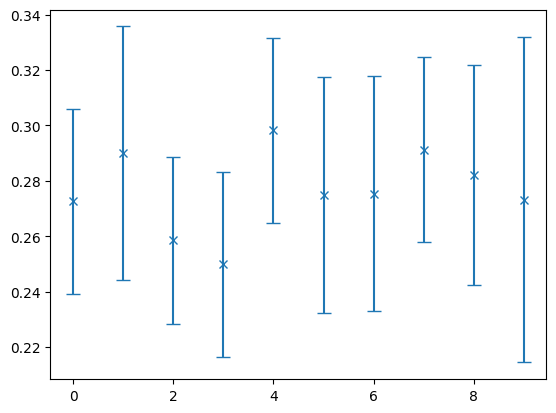

In [46]:
data = np.array(data)
print(np.mean(data, axis=1))

all_mean = np.mean(data, axis=1)
plt.errorbar(range(len(data)), all_mean,fmt="x", yerr=[all_mean - data[:,0], data[:,1]-all_mean], capsize=5)